<h2 align=center> Withdrawal Code Classification Using 1D CNN with Keras </h2>

#### Purpose:  Classify school district's raw withdraw code into CEPR standard code

## Part 1: Import Packages and Functions

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
print(tf.__version__)

2.2.0


In [156]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

## Part 2: Load and Explore Data

#### 2.1 Read in Data 

In [157]:
df = pd.read_csv('~/Desktop/projects/clean_withdrawal_2.csv') 
df.sample(5, random_state=1)

,source,schoolyear,raw_desc,exit_code,exit_desc
101,DCPS,2020,Enrolled but never attended,2.0,Drop out
578,KIPPDC,2018,Discharge: withdrawn for ineligibility reasons,1.0,Transfer out other
410,CCSD,2018,Transferred to Home Schooling,1.0,Transfer out other
444,SCSD,2018,Left school: previously counted as a dropout: ...,2.0,Drop out
521,SDPBC,2018,"""Any student who graduated from school\nwith a...",3.0,Graduated


In [158]:
x = df['raw_desc'].values
print(x[:5])

['Community School or GED program' 'Earned commencement credential' '0'
 'Special education eligibility status determined or determination process stopped for any reason'
 'Transferred to another school in this district or to an out-of-district placement']


In [159]:
# View few of "drop out" desc
df.loc[df['exit_code']==2].sample(5, random_state=1)

,source,schoolyear,raw_desc,exit_code,exit_desc
149,MC,2020,PURSUED EMPLOYMENT/WORK PERMIT - SUPT. APPROVA...,2.0,Drop out
208,SDPBC,2020,Adult student left due to health problems,2.0,Drop out
553,KIPPDC,2018,Withdrew,2.0,Drop out
116,DCPS,2020,Discontinued schooling,2.0,Drop out
597,DCPS,2017,Non-attending spec ed,2.0,Drop out


#### 2.2 Explore vars

In [160]:
# explore shapes
print(df.shape)  # 636 rows

# number of unique sources in data
print(df['source'].nunique()) # 18 different sources

# number of school years
print(df['schoolyear'].nunique()) # why 9; probably data not read in correctly - skip for now
print(df.groupby('schoolyear').count()) # weird rows with schoolyear 1-7

# for now, only keep school year between 2017-2020
df = df[df['schoolyear']>=2017]
print(df.groupby('schoolyear').count())
print(df.shape) # reduced to 599 rows

# drop if raw_desc or exit_code is null
df = df[(df['raw_desc'].notna()) & (df['exit_code'].notna())]
print(df.shape)

# look at exit_code
temp_df = df[['exit_code','exit_desc']]
print(df.groupby('exit_code').count()) # there are classes with only a few rows 

(636, 5)
17
9
            source  raw_desc  exit_code  exit_desc
schoolyear                                        
1                0        10          0          0
2                1         6          0          0
3                0        15          0          0
4                0         4          0          0
7                0         2          0          0
2017            29        29         29         29
2018           199       199        186        186
2019            86        84         86         86
2020           285       259        261        261
            source  raw_desc  exit_code  exit_desc
schoolyear                                        
2017            29        29         29         29
2018           199       199        186        186
2019            86        84         86         86
2020           285       259        261        261
(599, 5)
(534, 5)
           source  schoolyear  raw_desc  exit_desc
exit_code                                         

#### 2.3 Clean exit_code

In [161]:
# check exit_code with exit_desc to see if any of classes can be grouped together
print(temp_df.drop_duplicates().sort_values(by='exit_code')) 

     exit_code                                 exit_desc
30      -999.0                          To be determined
3          1.0                        Transfer out other
2          2.0                                  Drop out
0          3.0                                 Graduated
22         4.0                            Still enrolled
533        5.0                       Transfer to charter
92         6.0  Transfer to other school within district
5          7.0     Transfer to other school within state
159        8.0                            Never Enrolled


In [162]:
# combine 'transfer within district' with 'still enrolled'
df['exit_code'] = df['exit_code'].replace(6,4)

# combine 'transfer to charter/other district' with 'transfer out'
df['exit_code'] = df['exit_code'].replace([5,7],1)

# drop rows with 'To be determined' / 'never enrolled'
df = df[df['exit_code'] != -999] 
df = df[df['exit_code'] != 8] 

print(df.shape) # 520

(520, 5)


1.0    236
2.0    187
4.0     58
3.0     39
Name: exit_code, dtype: int64
transfer     236
dropout      187
enrolled      58
graudated     39
Name: grouped_exit_desc, dtype: int64


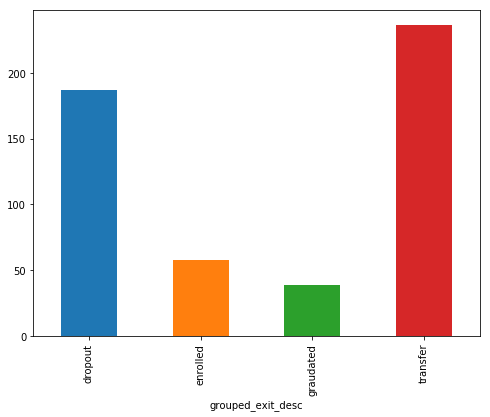

In [163]:
# change exit_desc according to the exit_code 
df['grouped_exit_desc'] = df['exit_desc']

def conditions(s):
    if (s['exit_code']==1):
        return "transfer"
    elif (s['exit_code']==2):
        return "dropout"
    elif (s['exit_code']==3):
        return "graudated"
    else:
        return "enrolled"
    
df['grouped_exit_desc'] = df.apply(conditions, axis=1)

print(df['exit_code'].value_counts())
print(df['grouped_exit_desc'].value_counts())

# make a histogram for the distribution of withdrawal code
fig = plt.figure(figsize=(8,6))
df.groupby('grouped_exit_desc').grouped_exit_desc.count().plot.bar(ylim=0)
plt.show()

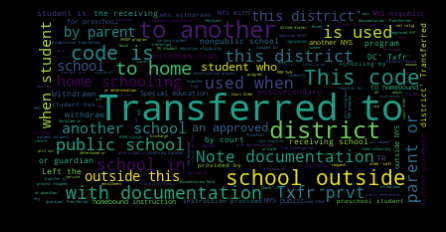

In [164]:
from wordcloud import WordCloud, STOPWORDS

# word cloud for tranfser out
text = df['raw_desc'].loc[df['exit_code']==1].values

wordcloud = WordCloud( 
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.show()

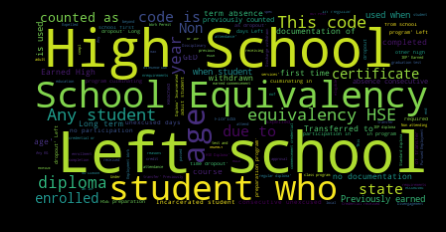

In [165]:
# word cloud for dropout
text = df['raw_desc'].loc[df['exit_code']==2].values

wordcloud = WordCloud( 
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.show()

#### 2.4 Split train and test data set

In [173]:
# save 
x = df['raw_desc'].values
y = df['exit_code'].values

# label incode y so that y is in [0,1,2,3]
from sklearn.preprocessing import LabelEncoder  
le = LabelEncoder() 
y= le.fit_transform(y)

# split into train and test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.2)


print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(416,) (104,)
(416,) (104,)


In [277]:
print(y[:15])

[2 2 1 0 0 0 0 0 0 0 0 0 1 0 1]


## Part  3: Data Prep — Tokenize and Pad Text Data

In [174]:
# get maximum length of string
max_len = -1
for ele in x_train: 
    if len(ele) > max_len: 
        max_len = len(ele) 
        res = ele 
print(res)
print(len(res)) # 782; surprisingly long!

Transferred to another school in this district: This code is used when a student transfers to a school within the same school district. This code is also used when a student has been promoted out of the highest grade that his current/last school offers and is expected to be registered in and attend another school in this district. Or when a student is placed in an out-of-district setting by the school or district administrators or agents for any reason. (Note: The out-of-district setting could be a BOCES, an approved-private placement, a State school, or another public school district.) This code may be used for transfers that take place at the end of the school year or at any point during the school year. For example: The hearing impaired program at the Solvay Elementary
782


In [175]:
max_features = 20000
max_text_length = 400

In [176]:
# toeknize x_train
x_tokenizer = tf.keras.preprocessing.text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x_train))
x_tokenized = x_tokenizer.texts_to_sequences(x_train) 
    #list of lists(containing numbers), so basically a list of sequences, not a numpy array
    #pad_sequences:transform a list of num_samples sequences (lists of scalars) into a 2D Numpy array of shape 

x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

In [177]:
print(x_train_val.shape)

(416, 400)


## Part 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [178]:
# Download and extract GloVe embeddings
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [179]:
embedding_dims = 100
embeddings_index = dict()

f = open('glove.6B.100d.txt')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((max_features, embedding_dims))

for word, index in x_tokenizer.word_index.items():
  if index > max_features -1:
    break
  else:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

## Part 5: Build a Model using Convolutional Neural Networks

#### 5.1 Create Embedding Layer

In [183]:
model = Sequential()
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
#load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
#(we don't want to update them during training).
model.add(Embedding(max_features,
                    embedding_dims,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))

#### 5.2 Set Hyperparameters

In [237]:
filters = 250
kernel_size = 3
hidden_dims = 250

#### 5.3 Build the full model 

In [185]:
# Add Conv1D
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
# we use max pooling
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

# use softmax activation function
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 250)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)              

In [187]:
# compile model: since the target var is label encoder - need to use 'sparse categorical crossentropy'
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## Part 6: Train Model

In [278]:
# split train to train-validation set. 
x_tr, x_val, y_tr, y_val = train_test_split(x_train_val, y_train, test_size=0.15, random_state=1)

In [279]:
print(x_tr.shape)
print(x_val.shape)

print(y_tr.shape)
print(y_val.shape)

(353, 400)
(63, 400)
(353,)
(63,)


In [281]:
# fit the model

batch_size = 32
epochs = 3

model.fit(x_tr, y_tr,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))


Epoch 1/3
12/12 [==============================] - 2s 139ms/step - loss: 0.0742 - accuracy: 0.9688 - val_loss: 0.6162 - val_accuracy: 0.8571
Epoch 2/3
12/12 [==============================] - 2s 139ms/step - loss: 0.0682 - accuracy: 0.9745 - val_loss: 0.6335 - val_accuracy: 0.8413
Epoch 3/3
12/12 [==============================] - 2s 132ms/step - loss: 0.0703 - accuracy: 0.9688 - val_loss: 0.6375 - val_accuracy: 0.8571


In [200]:
# fit the model using different batch size and epochs
batch_size = 8
epochs = 10

model.fit(x_tr, y_tr,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))


Epoch 1/10
45/45 [==============================] - 2s 39ms/step - loss: 0.1446 - accuracy: 0.9490 - val_loss: 0.4910 - val_accuracy: 0.8571
Epoch 2/10
45/45 [==============================] - 2s 38ms/step - loss: 0.1397 - accuracy: 0.9575 - val_loss: 0.5520 - val_accuracy: 0.8571
Epoch 3/10
45/45 [==============================] - 2s 39ms/step - loss: 0.1072 - accuracy: 0.9632 - val_loss: 0.8937 - val_accuracy: 0.8254
Epoch 4/10
45/45 [==============================] - 2s 41ms/step - loss: 0.1257 - accuracy: 0.9575 - val_loss: 0.4925 - val_accuracy: 0.8571
Epoch 5/10
45/45 [==============================] - 2s 40ms/step - loss: 0.1105 - accuracy: 0.9688 - val_loss: 0.5316 - val_accuracy: 0.8571
Epoch 6/10
45/45 [==============================] - 2s 40ms/step - loss: 0.1219 - accuracy: 0.9603 - val_loss: 0.7799 - val_accuracy: 0.7937
Epoch 7/10
45/45 [==============================] - 2s 45ms/step - loss: 0.1328 - accuracy: 0.9547 - val_loss: 0.5564 - val_accuracy: 0.8413
Epoch 8/10
45

## Task 7: Evaluate Model

In [282]:
# evaluate 
model.evaluate(x_val, y_val, batch_size=128)

1/1 [==============================] - 0s 1ms/step - loss: 0.6375 - accuracy: 0.8571


[0.6375194787979126, 0.8571428656578064]

In [202]:
# process x_test
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)

In [211]:
y_pred = np.argmax(model.predict(x_testing, verbose = 1, batch_size=32), axis=-1)
#y_testing = model.predict_classes(x_testing, verbose = 1, batch_size=32)

4/4 [==============================] - 0s 31ms/step


In [214]:
print(y_pred)
y_pred.shape

[0 0 0 1 3 0 2 0 1 0 0 1 0 1 1 0 0 1 0 0 1 2 0 0 1 2 1 2 0 1 3 1 0 0 0 0 0
 1 2 0 1 0 3 0 0 0 0 3 0 3 2 2 1 3 1 3 1 3 0 2 0 1 0 2 0 0 0 0 3 0 2 1 3 2
 0 1 0 0 0 0 2 0 1 2 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 2 1 1 1 2]


(104,)

In [219]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred,average=None)) # What proportion of positive identifications was actually correct?
print("Recall score:", recall_score(y_test, y_pred,average=None)) # What proportion of actual positives was identified correctly?

Accuracy score: 0.75
Precision score: [0.82978723 0.875      0.46666667 0.4       ]
Recall score: [0.8125     0.65116279 0.875      0.8       ]


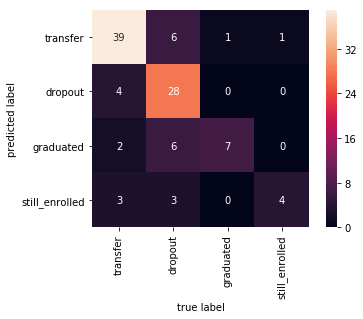

In [235]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# confusion matrix
mat = confusion_matrix(y_test, y_pred)

mat = pd.DataFrame(mat, index=["transfer", "dropout", "graduated", "still_enrolled"], 
                     columns=["transfer", "dropout", "graduated", "still_enrolled"])

sns.heatmap(mat.T, square=True, annot=True, fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [262]:
# merge them to make a full test data set
test = pd.DataFrame(x_test, columns=['raw_desc']) 
test['true'] = y_test
test['predicted'] = y_pred
print(test.head(10))

                                            raw_desc  true  predicted
0  Transferred to home schooling by parent or gua...     0          0
1  Transferred to a NYS nonpublic school with doc...     0          0
2  Transferred to home schooling by parent or gua...     0          0
3                             Discontinued schooling     1          1
4                          Under required attend age     1          3
5                          WD FROM PRESCHOOL PROGRAM     0          0
6  Standard diploma - 18-credit college prep opti...     1          2
7               Transferred Out of the United States     0          0
8                        Parents Missed Doc Deadline     0          1
9                               Retention Withdrawal     1          0


In [269]:
# check codes where true label was dropout but misclassified
print("true label 'dropout' but misclassified ")
test.loc[(test['true']==1) & (test['predicted']!= 1)]


true label 'dropout' but misclassified 


,raw_desc,true,predicted
4,Under required attend age,1,3
6,Standard diploma - 18-credit college prep opti...,1,2
9,Retention Withdrawal,1,0
25,Enrolled but never attended,1,2
27,Enrolled but never attended,1,2
30,Under required attend age,1,3
36,NoKnownEnrollTruant,1,0
38,GED Outside Texas,1,2
45,TransInstNoHSDipl,1,0
47,RES. DISTRICT NO LONGER RESPONSIBLE FOR STUDENT,1,3


In [283]:
# check codes where true label was transferred but misclassified
print("true label 'transfer' but misclassified ")
test.loc[(test['true']==0) & (test['predicted']!= 0)]



true label 'transfer' but misclassified 


,raw_desc,true,predicted
8,Parents Missed Doc Deadline,0,1
21,Transferred to an approved HSE program outside...,0,2
42,Alternate Placement,0,3
50,Graduated outside Texas,0,2
55,Enroll in University HS diploma,0,3
56,Withdraw Foreign Exchange Student: This code i...,0,1
57,School Changed Location,0,3
89,Any student who withdraws from school due to p...,0,1
100,"""Any KG-12 student who withdraws from\r\nschoo...",0,1


#### next step is to clean and pre-process the data more before running the model